# Example on memory cutoff

We have a look at different maximal correlation times `max_correlation_time` for a constant `dkmax`.

When the timestep succeeds `dkmax` then the last influence functional captures the correlations up to `max_correlation_time` into the past. If `max_correlation_time` is `None`, then the last influence functional captures all correlations back to the start time (like proposed in [Strathearn2017]).

**[Strathearn2017]** A. Strathearn, B.W. Lovett, and P. Kirton, 2017. *Efficient real-time path integrals for non-Markovian spin-boson models*. [New Journal of Physics, 19(9), p.093009](https://doi.org/10.1088/1367-2630/aa8744).

In [1]:
import sys
sys.path.insert(0,'..')
import os
from time import time

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import time_evolving_mpo as tempo
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook

## A: Independent Spin Boson Model

In [2]:
Omega = 1.0
omega_cutoff = 3.0
alpha = 0.1
temperature = 0.0
start_time = 0.0
end_time = 8.0
initial_state = tempo.operators.spin_dm("y+")

system = tempo.System(0.0 * Omega * tempo.operators.sigma("x"))

max_corr_list = [2.0, 3.0, None]
correlations_list = []
bath_list = []
for max_corr in  max_corr_list:
    correlations = tempo.PowerLawSD(alpha=alpha, 
                                    zeta=3, 
                                    cutoff=omega_cutoff, 
                                    cutoff_type='exponential',
                                    temperature=temperature,
                                    max_correlation_time=max_corr)
    correlations_list.append(correlations)
    bath_list.append(tempo.Bath(0.5 * tempo.operators.sigma("z"), correlations))

In [3]:
dt = 0.1
dkmax = 10
epsrel = 1.0e-6
tempo_parameters = tempo.TempoParameters(dt=dt, dkmax=dkmax, epsrel=epsrel)
pt_tempo_parameters = tempo.PtTempoParameters(dt=dt, dkmax=dkmax, epsrel=epsrel)

../time_evolving_mpo/helpers.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='$\\tau$', ylabel='$C(\\tau)$'>

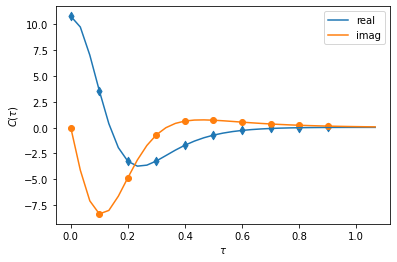

In [4]:
tempo.helpers.plot_correlations_with_parameters(correlations_list[0],tempo_parameters)

## B: TEMPO

In [5]:
t_tempo_list = []
sy_tempo_list = []
for bath in bath_list:
    tempo_sys = tempo.Tempo(system=system,
                            bath=bath,
                            parameters=tempo_parameters,
                            initial_state=initial_state,
                            start_time=start_time)
    tempo_sys.compute(end_time=end_time, progress_type='bar')

    dynamics = tempo_sys.get_dynamics()
    t, sy = dynamics.expectations(tempo.operators.sigma("y"), real=True)
    t_tempo_list.append(t)
    sy_tempo_list.append(sy)

100.0%   80 of   80 [########################################] 00:00:01
Elapsed time: 1.7s
100.0%   80 of   80 [########################################] 00:00:01
Elapsed time: 1.9s
100.0%   80 of   80 [########################################] 00:00:04
Elapsed time: 4.5s


## C: Process Tensor  TEMPO

In [6]:
# t_pt_tempo_list = []
# sy_pt_tempo_list = []
# for bath in bath_list:
#     pt = tempo.pt_tempo_compute(bath=bath,
#                                 start_time=start_time,
#                                 end_time=end_time,
#                                 parameters=pt_tempo_parameters,
#                                 progress_type='bar')
#     dynamics = pt.compute_dynamics_from_system(system=system, initial_state=initial_state)
#     t, sy = dynamics.expectations(tempo.operators.sigma("y"), real=True)
#     t_pt_tempo_list.append(t)
#     sy_pt_tempo_list.append(sy)

## D: Analytic Solution

In [7]:
def analytic_solution(t):
    x = (t*omega_cutoff)**2
    phi = 2 * alpha * (1 + (x-1)/(x+1)**2)
    return np.exp(-phi)
t_exact = t_tempo_list[0]
sy_exact = analytic_solution(t_exact)

## E: Plots

<IPython.core.display.Javascript object>


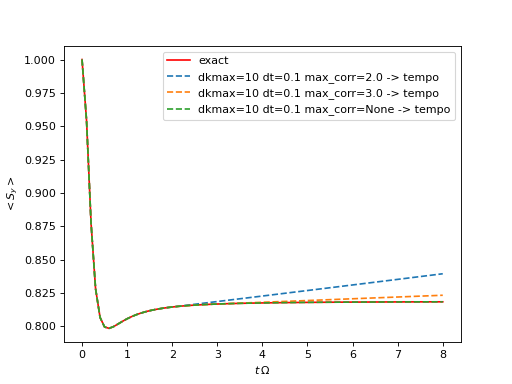

In [8]:
%matplotlib notebook
plt.plot(t_exact, sy_exact, label=f'exact', linestyle="solid", color="red")

for i, max_corr in enumerate(max_corr_list):
    plt.plot(t_tempo_list[i], 
             sy_tempo_list[i], 
             linestyle="dashed", 
             label=f'dkmax={dkmax} dt={dt} max_corr={max_corr} -> tempo')
#     plt.plot(t_pt_tempo_list[i], 
#              sy_pt_tempo_list[i], 
#              linestyle="dotted", 
#              label=f'dkmax={dkmax} dt={dt} max_corr={max_corr} -> pt-tempo')

plt.xlabel(r'$t\,\Omega$')
plt.ylabel(r'$<S_y>$')
plt.legend()